<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/03_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    IV - Modélisation
</p>

# 1. Préparation des données

In [104]:
# Forcer l'installation de la version 1.5.2 pour palier à une regression de scikit-learn qui impacte la librairie xgboost
# Line vers l'issue https://github.com/scikit-learn/scikit-learn/issues/30479

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import warnings
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ConfusionMatrix
from collections import Counter

In [106]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [107]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

In [108]:
X_train.drop(columns=['SK_ID_CURR'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [109]:
X_train['TARGET'].isna().sum()

0

In [110]:
# Fonction pour afficher le diagramme en camembert
def plot_pie_chart(values, classes, title, ax):
    #plt.figure(figsize=(6, 6))
    ax.pie(values, labels=classes, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    ax.set_title(title)

TARGET
0    282686
1     24825
Name: count, dtype: int64


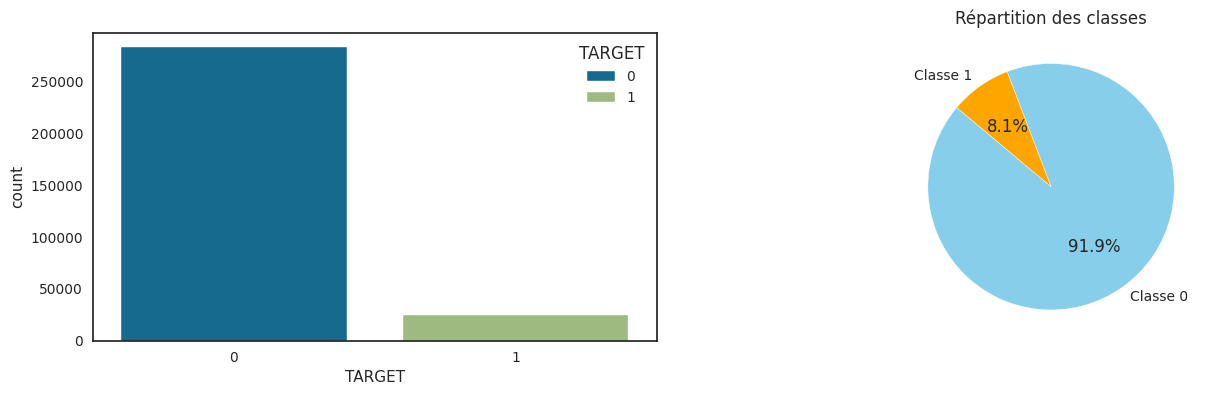

In [111]:
print(y.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(X_train.TARGET.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=y.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

In [112]:
# Le ratio du desequilibre
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


# Equilibrage des classes

In [113]:
y = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)
X_train = SimpleImputer(strategy="median").fit_transform(X_train)
X_train, y = SMOTE(random_state=42).fit_resample(X_train, y)

TARGET
1    282686
0    282686
Name: count, dtype: int64


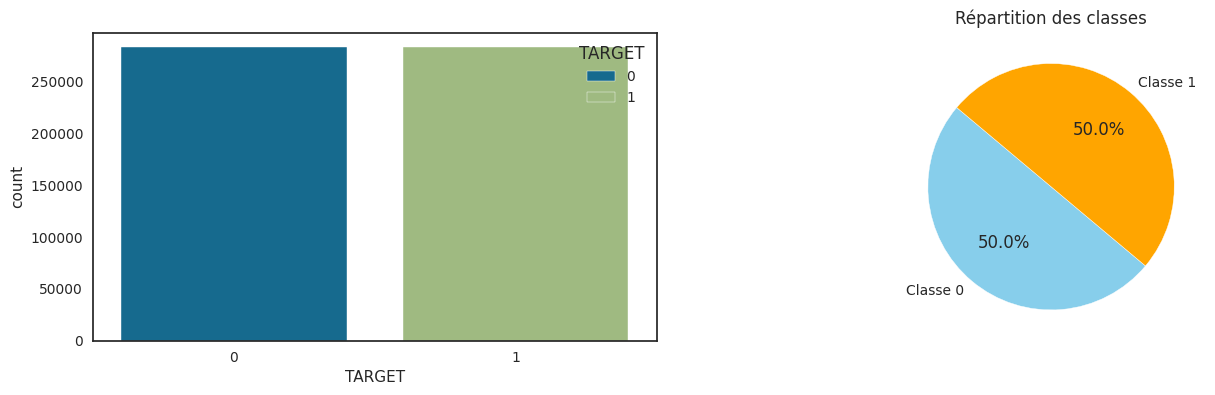

In [114]:
print(y.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(y.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=y.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

In [115]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify=y, test_size=0.3, random_state=42)
X_Xtrain.shape, X_valid.shape

((395760, 14), (169612, 14))

In [11]:
# Fonction pour calculer le coût métier
def business_cost(y_true, y_pred):
    """
    Calcule le coût métier en fonction des faux négatifs et faux positifs.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes (0 ou 1).
    y_pred (array-like) : Les prédictions du modèle (0 ou 1).

    Retourne :
    float : Le coût métier basé sur 10 * FN + FP.
    """
    # Matrice de confusion : [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût métier
    cost = 10 * fn + fp
    return cost

# Scorer pour le coût métier
business_scorer = make_scorer(business_cost, greater_is_better=False)

# 2. Dummy Classifier

Metric accuray: 0.9192663732737876
Metric roc_auc: 0.5
Metric f1: 0.0
Metric Metier: 74480
Matrice de confusion:
[[84806     0]
 [ 7448     0]]


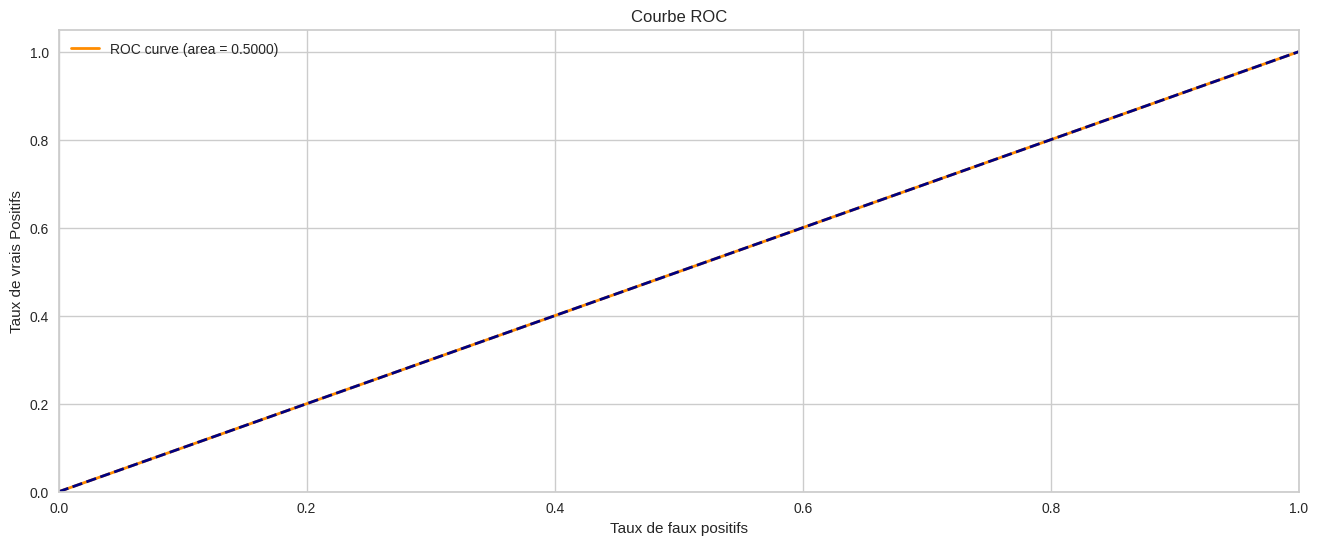

In [12]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_Xtrain, y_train)

# Prédictions
y_pred = dummy_clf.predict(X_valid)
y_prob = dummy_clf.predict_proba(X_valid)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_prob)
f1 = f1_score(y_valid, y_pred)

# Metric metier
cost = business_cost(y_valid, y_pred)

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Metric accuray: {accuracy}")
print(f"Metric roc_auc: {roc_auc}")
print(f"Metric f1: {f1}")
print(f"Metric Metier: {cost}")

print(f"Matrice de confusion:\n{conf_matrix}")

fpr, tpr, _ = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(16, 6))

# Visualiser la courbe ROC AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")
plt.show()

In [13]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    "SVM": SVC(probability=True, kernel='linear', random_state=42, cache_size=700),
    "Naive Bayes": GaussianNB()
}

# Grilles d'hyperparamètres
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__class_weight": [None, "balanced"]
    },
    "Random Forest": {
        "model__n_estimators": [10, 100],
        "model__max_depth": [3, 6],
        "model__class_weight": [None, "balanced"]
    },
    "XGBoost": {
        "model__n_estimators": [10, 100],
        "model__learning_rate": [0.1, 0.2],
        "model__max_depth": [6, 10],
        "model__scale_pos_weight": [1, 5, 10]
    },
    "LightGBM": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.01, 0.1, 0.2, 0.3],
        "model__max_depth": [6, 10],
        "model__scale_pos_weight": [1, 5, 10]
    },
    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__gamma": [1, 0.1, 0.01]
    }
}


In [37]:
# Résultats des modèles
model_results = {}
import os
if os.path.exists(f"{folder_path}grid_search_results.pkl"):
    with open(f"{folder_path}grid_search_results.pkl", "rb") as f:
        model_results = pickle.load(f)

In [27]:
# Un decorateur pour tracker le temps d'execution des modéles
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Temps d'entrainement du modèle {kwargs.get('model_name')}: {execution_time:.2f} secondes")
        return result
    return wrapper

In [116]:
@timer
def evaluate_model(model_name, X_train, y_train, X_valid, y_valid, force=True):
  """
  Entrainer un modèle, prédire sur l'ensemble de validation et évaluer les performances.

  Paramètres :
  model_name : Le nom modèle à entraîner.
  X_train, y_train : Les données d'entraînement.
  X_valid, y_valid : Les données de validation.

  Retourne :
  obj: Les résultats de l'évaluation du modèle.
  """
  print(f"Évaluation du modèle : {model_name}")

  # Pipeline avec SMOTE
  pipeline = ImbPipeline(steps=[
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler()),
      ("model", models[model_name])
  ])

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # GridSearchCV
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=param_grids[model_name],
      scoring={
          "business_score": business_scorer,
          "AUC": "roc_auc",
          "F1": "f1",
          "Accuracy": "accuracy",
          "Recall": "recall",
          "Precision": "precision",
          "F2": make_scorer(fbeta_score, beta=2)
      },
      refit="business_score",  # Optimisation basée sur le score métier
      cv=cv,
      verbose=1,
      return_train_score=True
  )

  # Entraînement
  if force or model_name not in model_results:
    grid_search.fit(X_train, y_train)
    model_results[model_name] = grid_search
  else:
    grid_search = model_results[model_name]

  # Sauvegarder les resultats, pour eviter plus tard le coùt de calcul
  with open(f"{folder_path}grid_search_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

  y_pred = grid_search.predict(X_valid)
  y_prob = grid_search.predict_proba(X_valid)[:, 1]

  # Résultats
  print("Meilleurs paramètres :", grid_search.best_params_)
  print("Meilleur score métier :", grid_search.best_score_)
  print("Matrice de confusion :", confusion_matrix(y_valid, y_pred))

  fpr, tpr, _ = roc_curve(y_valid, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

  # Récupérer les scores pour chaque combinaison d'hyperparamètres
  scores = -grid_search.cv_results_['mean_test_business_score']
  params = grid_search.cv_results_['params']

  # Visualiser notre score metier
  ax0.plot(range(len(scores)), scores, marker='o')
  ax0.set_title("Score métier pour chaque combinaison d'hyperparamètres")
  ax0.set_xlabel("Index de la combinaison d'hyperparamètres")
  ax0.set_ylabel("Score métier (plus bas est meilleur)")
  ax0.set_xticks(range(len(scores)), labels=[str(p) for p in params], rotation=90)
  ax0.grid(True)

  # Visualiser la courbe ROC AUC
  ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
  ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax1.set_xlim([0.0, 1.0])
  ax1.set_ylim([0.0, 1.05])
  ax1.set_xlabel('Taux de faux positifs')
  ax1.set_ylabel('Taux de vrais Positifs')
  ax1.set_title('Courbe ROC')
  ax1.legend(loc="upper left")

  plt.show()

  print("-" * 50)
  return grid_search

In [29]:
def visualize_confusion_matrix(model, X_valid, y_valid, classes=['non_defaut_payment', 'defaut_payment']):
  sns.set_style("ticks")
  fig, ax = plt.subplots(figsize=(6, 4))
  cm = ConfusionMatrix(model, classes=classes)
  cm.fit(X_train, y_train)
  cm.score(X_valid, y_valid)
  cm.show()

# 3. RandomForest

Évaluation du modèle : Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__class_weight': None, 'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : -26282.2
Matrice de confusion : [[57841 26965]
 [ 2909  4539]]


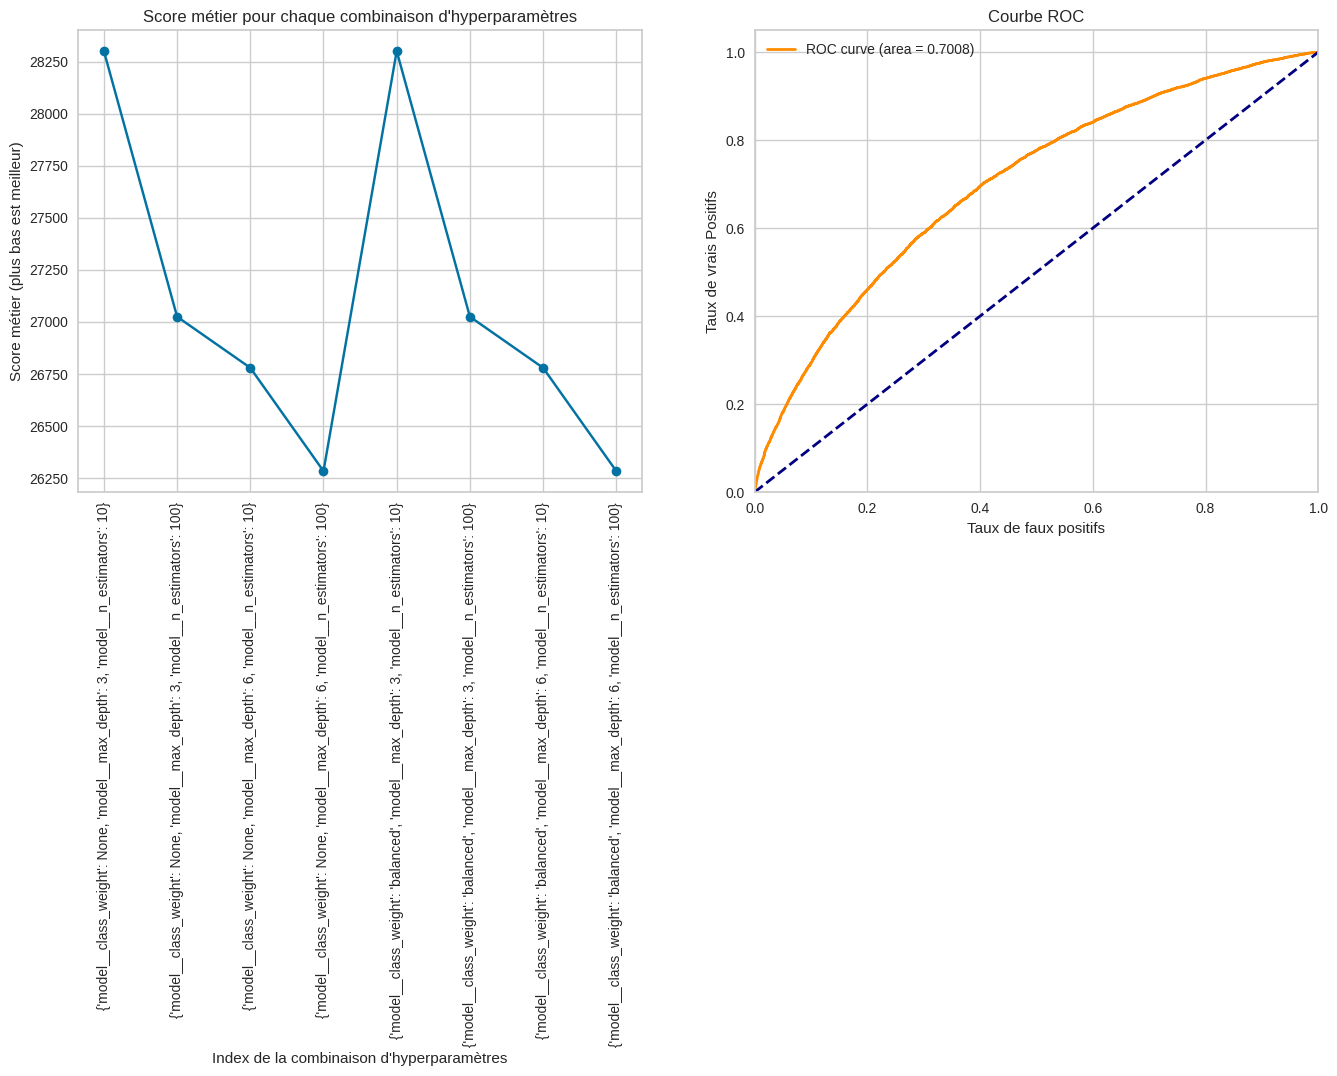

--------------------------------------------------
Temps d'entrainement du modèle Random Forest: 351.06 secondes


In [30]:
res = evaluate_model(model_name='Random Forest', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


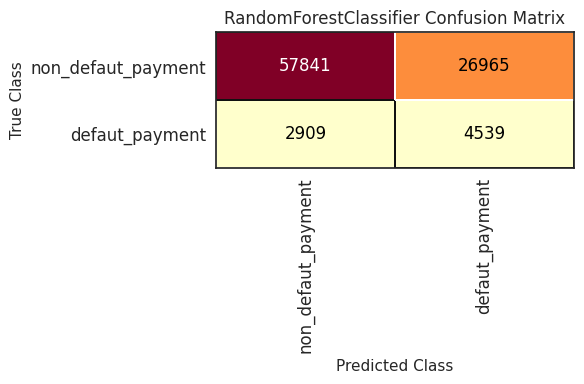

In [31]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

Le modèle a correctement identifié **57 020** cas comme négatifs (TN) et **4 632** cas comme positifs (TP). Cependant, il a également commis des erreurs en identifiant **27 786** cas négatifs comme positifs (FP) et en manquant **2 816** cas positifs en les identifiant comme négatifs (FN).

# 4. Logistic Regression

Évaluation du modèle : Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres : {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2'}
Meilleur score métier : -138899.8
Matrice de confusion : [[58292 26514]
 [27099 57707]]


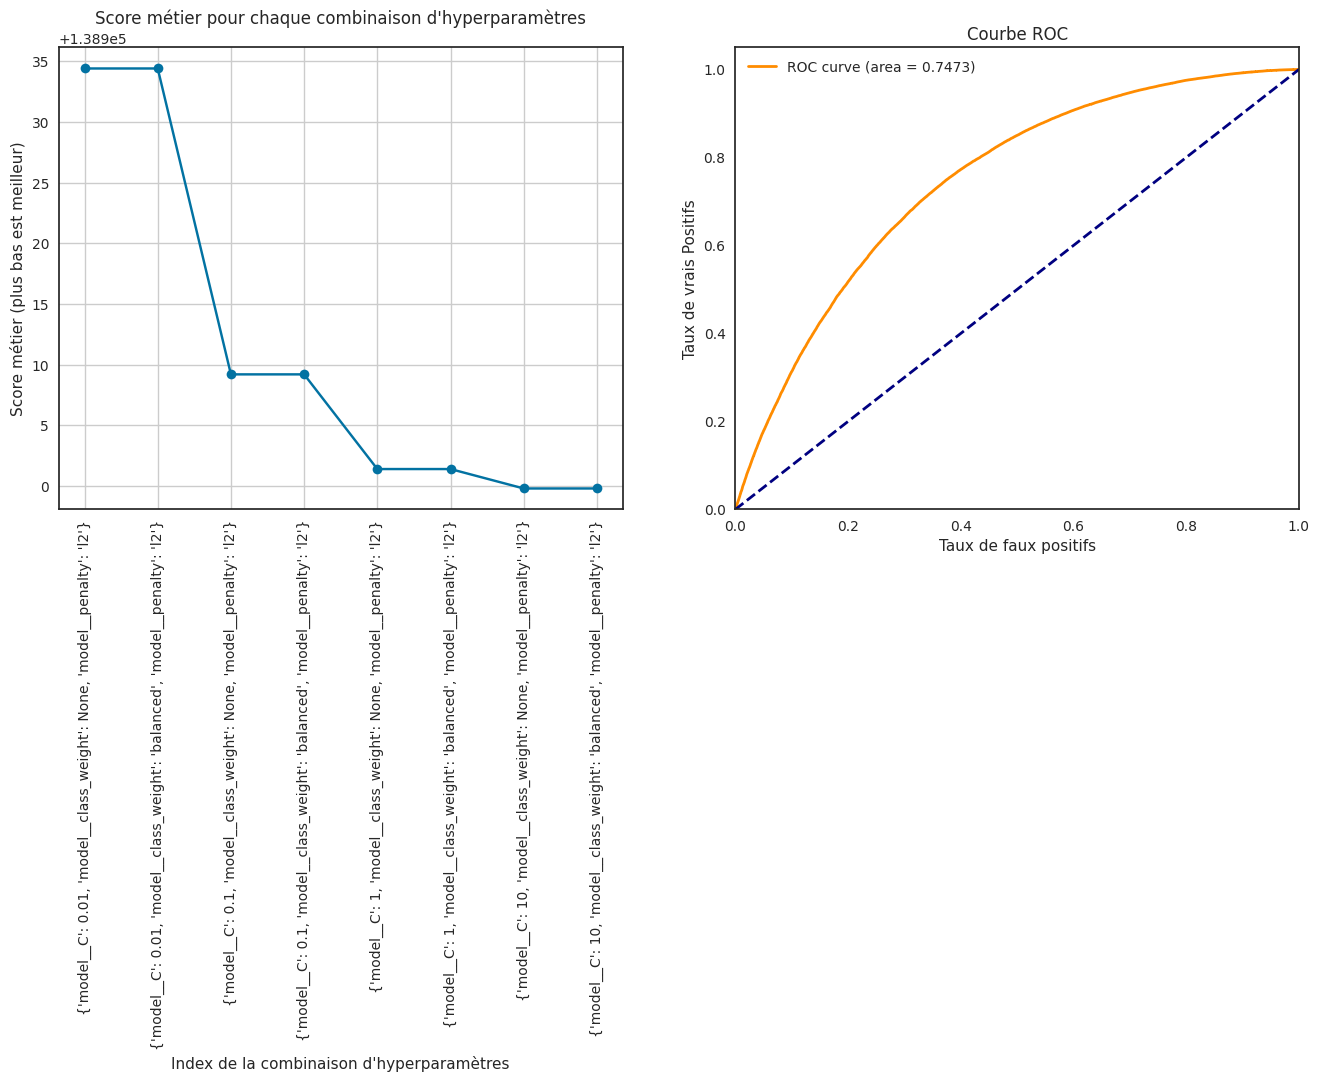

--------------------------------------------------
Temps d'entrainement du modèle Logistic Regression: 109.32 secondes


In [117]:
res = evaluate_model(model_name='Logistic Regression', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


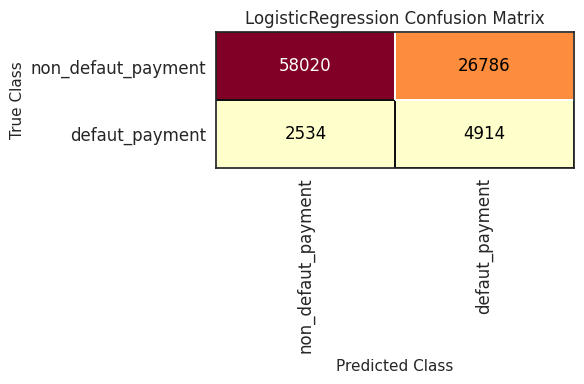

In [33]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

- Le modèle de Régression Logistique a correctement identifié 57 940 cas comme négatifs (TN) et 4 893 cas comme positifs (TP).

- Cependant, il a également commis des erreurs en identifiant 26 866 cas négatifs comme positifs (FP) et en manquant 2 555 cas positifs en les identifiant comme négatifs (FN).

# 5. LightGBM

In [ ]:
warnings.simplefilter("ignore", FutureWarning)
res = evaluate_model(model_name='LightGBM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Évaluation du modèle : LightGBM
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

- Le modèle LightGBM a correctement identifié 65 013 cas comme négatifs (TN) et 3 888 cas comme positifs (TP).
- Cependant, il a également commis des erreurs en identifiant 19 793 cas négatifs comme positifs (FP) et en manquant 3 560 cas positifs en les identifiant comme négatifs (FN).


# 6. XGBoost

In [ ]:
warnings.simplefilter("ignore", UserWarning)
res = evaluate_model(model_name='XGBoost', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

# 7. SVM

In [ ]:
res = evaluate_model(model_name='SVM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Évaluation du modèle : SVM
Fitting 5 folds for each of 9 candidates, totalling 45 fits


# 8. Naive Baise

In [ ]:
res = evaluate_model(model_name='Naive Bayes', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

# 9. Comparaison des modéles

In [118]:
metrics = [
    'business_score',
    'AUC',
    'F1',
    'Accuracy',
    'Recall',
    'Precision',
    'F2'
]

cv_results = {}
for key, grid_search in model_results.items():
    results = grid_search.cv_results_
    t = {}
    for metric in metrics:
      score = f"{results[f'mean_test_{metric}'][grid_search.best_index_]:.4f}"
      t[metric] = score
    cv_results[key] = t

metrics_df = pd.DataFrame(cv_results)
metrics_df.T

,business_score,AUC,F1,Accuracy,Recall,Precision,F2
Random Forest,-26282.2000,0.6979,0.2314,0.6724,0.6106,0.1427,0.3688
Logistic Regression,-138899.8000,0.7462,0.6825,0.6835,0.6804,0.6846,0.6812


Le tableau recapitulatif ci-dessus nous montre que le modéle **Logistic Regression** est le modèle le plus performant avec un coût métier de -24 649,8 et des métriques solides. Il affiche un AUC de 0,7262, ce qui indique une bonne capacité à distinguer entre les classes. Son rappel de 65,42 % montre une capacité élevée à détecter les défauts de paiement, tout en limitant les faux positifs (27 017). Le F1-score de 0,2474 et la précision de 65,42 % soulignent un compromis robuste entre la sensibilité (rappel) et la spécificité (précision). Le F2-score de 0,3946, qui donne davantage de poids au rappel, témoigne également de sa capacité à minimiser les faux négatifs, ce qui est essentiel dans ce type de problème.

LightGBM affiche un coût métier réduit à -25 968,4, mais son AUC de 0,7084 et son F1-score de 0,2287 indiquent une performance moins stable que celle de la régression logistique. Le modèle souffre d'une précision faible (13,75 %) et de nombreux faux positifs, malgré un rappel élevé de 67,84 %. Ce rappel élevé suggère que LightGBM est capable de détecter une bonne partie des défauts de paiement, mais le modèle a tendance à prédire trop de cas positifs, ce qui se reflète dans sa faible précision. Le F2-score de 0,3797 montre que, bien qu'il soit plus performant en termes de rappel, il n'est pas optimal en termes de coût métier.

XGBoost affiche des résultats similaires à LightGBM, avec un coût métier de -26 175 et un rappel de 59,55 %. Il présente un AUC de 0,7016, ce qui est légèrement inférieur à celui de Logistic Regression. Son F1-score de 0,2344 et son faible rappel suggèrent qu'il est moins performant dans la détection des défauts de paiement, bien que la précision de 14,59 % et le F2-score de 0,3684 indiquent qu'il reste compétitif en termes d’équilibre entre la détection des défauts et la réduction des faux positifs.

Random Forest, avec un coût métier élevé de -26 321,2, est le modèle le moins performant, avec un faible F1-score (0,2304) et un rappel modéré de 61,54 %. Bien que sa précision soit relativement meilleure que celle de LightGBM et XGBoost, il souffre d’un grand nombre de faux positifs, ce qui augmente son coût métier. Son AUC de 0,7025 indique une capacité correcte à différencier les classes, mais son rappel et son F2-score de 0,3688 suggèrent qu'il est moins efficace dans la gestion des faux négatifs par rapport aux autres modèles.

En conclusion, Logistic Regression reste le modèle le plus équilibré et adapté pour minimiser les pertes financières tout en maintenant des performances stables. Cependant, LightGBM et XGBoost pourraient être plus intéressants dans des contextes où l'on privilégie le rappel au détriment de la précision, bien que des ajustements supplémentaires de leurs hyperparamètres soient nécessaires pour optimiser leurs performances. Random Forest reste un choix sous-optimal pour ce cas particulier, en raison de son coût métier élevé et de son faible F1-score.